# Analysing individual Recommenders

In [1]:
import config
from src.utils.MetricsEvaluator import MetricsEvaluator
from src.utils.RecommendationUtils import RecommendationUtils
from config import experiment_years

data_stem = "../../scala-code/data/processed/"
rec_utils = RecommendationUtils(data_stem)
yr = 2008

initializing Metrics utilities for year 2005...
Ready!
initializing Metrics utilities for year 2008...
Ready!
initializing Metrics utilities for year 2012...
Ready!


In [ ]:
metrics_evaluators = {}
for yr in experiment_years:
    metrics_evaluators[yr] = MetricsEvaluator(yr)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

metrics_to_plot = ['MAR', 'MAR_filtered', 'NaN_Prop', 'Pers', 'Nov', 'Cov', 'Fam']
pretty_names = {
    'MAR': 'Mean Average Recall',
    'MAR_filtered': 'Mean Average Recall',
    'NaN_Prop': 'Proportion Unsuccessful Recommendation',
    'Pers': 'Personalization',
    'Nov': 'Novelty',
    'Cov': 'Coverage',
    'Fam': 'Familiarity',

    "CF_user-rec": "User-Record based Collaborative Filtering",
    "CF_user-artist": "User-Artist based Collaborative Filtering"
}

def f(params):
    k_, set_, model, year = params
    # print(f'k:{k_}\tset:{set_}')
    recs_ = rec_utils.get_recommendations_dict_single_model(year, model, set_, k_)
    m = metrics_evaluators[year].get_all_metrics(recs_, year, set_, k_)
    metrics_arr = []
    for metric_name in list(m.keys()):
        metrics_arr.append((k_, set_, metric_name, m[metric_name]))
    return metrics_arr

def get_df_per_k_set(model: str, processes:int = config.num_cpu):
    min_, max_ = 5, 50
    k_list = range(min_, max_, 10)
    models = [model]
    params = list(itertools.product(k_list, range(1,4), models, [yr]))

    temp_data = Pool(processes).map(f, params)
    data = []
    [data.append(y) for x in temp_data for y in x]
    df_ = pd.DataFrame(data, columns=['k', 'set', 'metric', 'val']).reset_index()
    df_ = df_[['k', 'metric', 'val']]\
        .groupby(['k', 'metric'])\
        .agg(['mean', 'std'])
    return df_.reset_index()

def plot_errorbars_single_recommender(data: pd.DataFrame, model: str, figsize:tuple=(12,5), yscale:str='linear'):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(f"{pretty_names[model]}\nmetrics errorbars at different list sizes")
    for metric in metrics_to_plot:
        df__ = data[data["metric"] == metric].reset_index()
        plt.errorbar(x=df__['k'],
                     y=df__['val']['mean'],
                     yerr=df__['val']['std'],
                     alpha=0.7,
                     label=pretty_names[metric])
    if yscale == 'linear':
        plt.ylim((-0.01,1.01))
    plt.yscale(yscale)

    plt.xlabel('Recommendation list size $k$')
    plt.ylabel("metric value (\\textbf{%s} scale)"% yscale)

    plt.legend(fontsize=7)
    plt.savefig(f'../images/single-recommenders/{model}_{yscale}.svg')

## User-Recording Collaborative Filtering

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


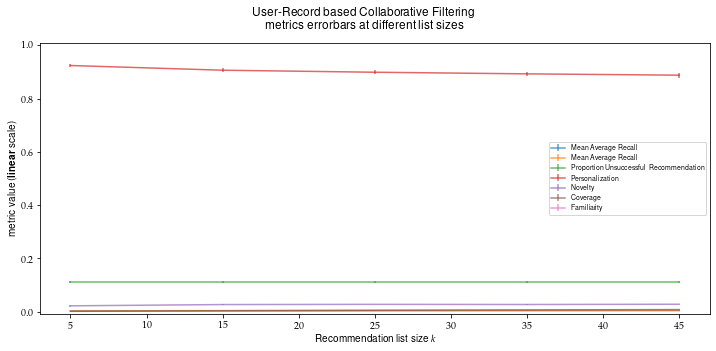

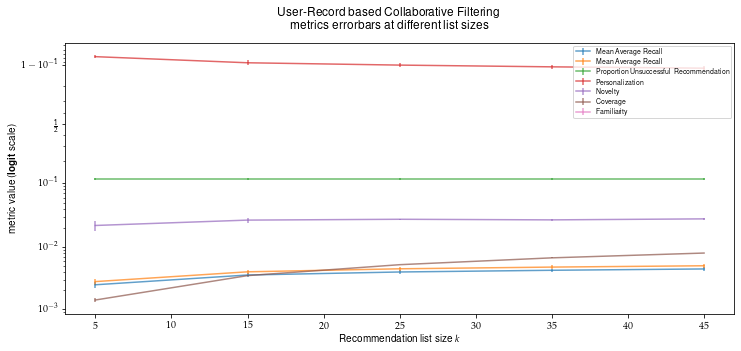

In [9]:
model_ = "CF_user-rec"
df = get_df_per_k_set(model_)
plot_errorbars_single_recommender(df, model=model_)
plot_errorbars_single_recommender(df, model=model_, yscale='logit')

## User-Artist Collaborative Filtering

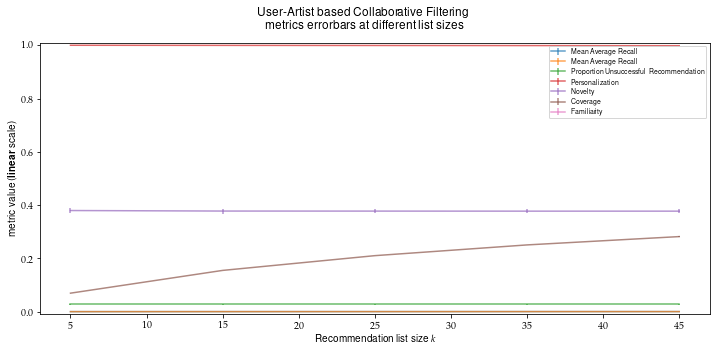

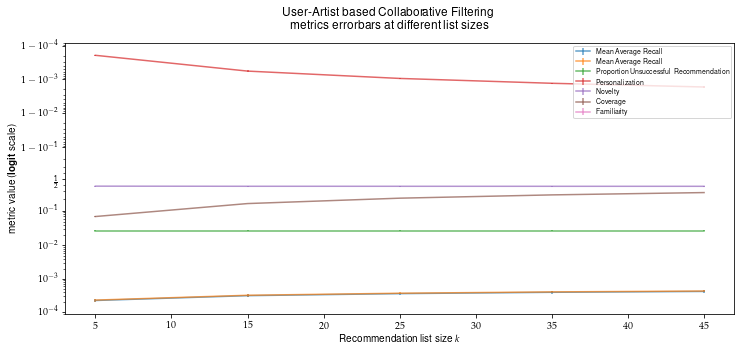

In [10]:
model_ = "CF_user-artist"
df = get_df_per_k_set(model_, processes = 5)
plot_errorbars_single_recommender(df, model=model_)
plot_errorbars_single_recommender(df, model=model_, yscale='logit')